In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import colour

from colour_checker_detection import (SETTINGS_SEGMENTATION_COLORCHECKER_CLASSIC,
    colour_checkers_coordinates_segmentation,
    detect_colour_checkers_segmentation)
from colour_checker_detection.detection.segmentation import (
    adjust_image)

/Users/andieich/miniconda3/envs/coral_pigmentation/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


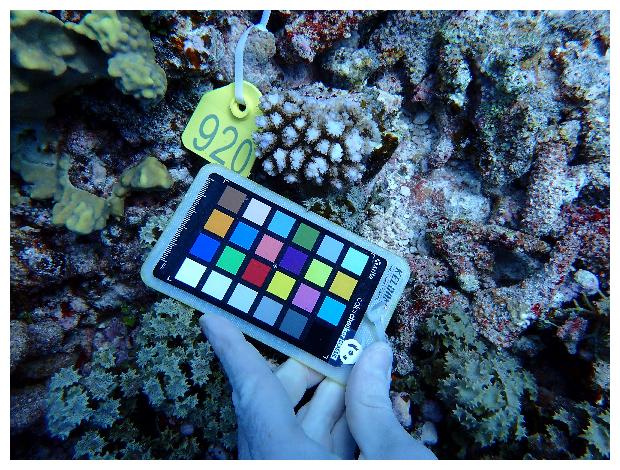

In [2]:
image_paths = glob.glob(
    os.path.join("photos", '*.jpg'))

images = [
    colour.cctf_decoding(colour.io.read_image(path))
    for path in image_paths
]

for image in images:
    colour.plotting.plot_image(colour.cctf_encoding(image));

/Users/andieich/miniconda3/envs/coral_pigmentation/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: Colour checker was seemingly flipped, reversing the samples!
  warn(*args, **kwargs)  # noqa: B028


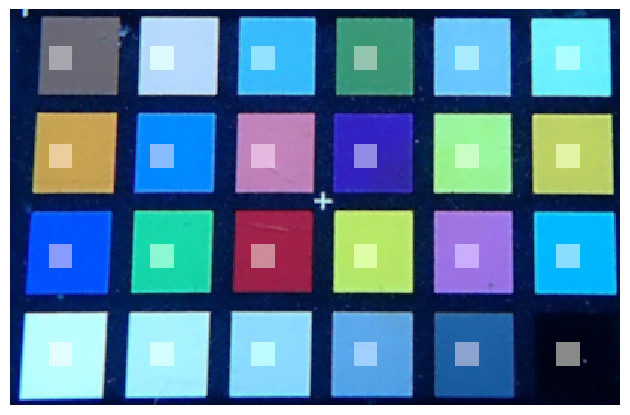

In [3]:
SWATCHES = []
for image in images:
    for colour_checker_swatches_data in detect_colour_checkers_segmentation(
        image, additional_data=True):
        swatch_colours, colour_checker_image, swatch_masks = (
            colour_checker_swatches_data.values)
        SWATCHES.append(swatch_colours)
        
        # Using the additional data to plot the colour checker and masks.
        masks_i = np.zeros(colour_checker_image.shape)
        for i, mask in enumerate(swatch_masks):
            masks_i[mask[0]:mask[1], mask[2]:mask[3], ...] = 1
        colour.plotting.plot_image(
            colour.cctf_encoding(
                np.clip(colour_checker_image + masks_i * 0.25, 0, 1)));


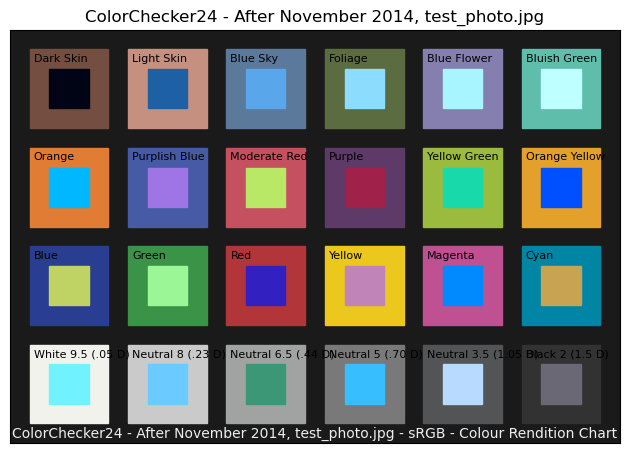

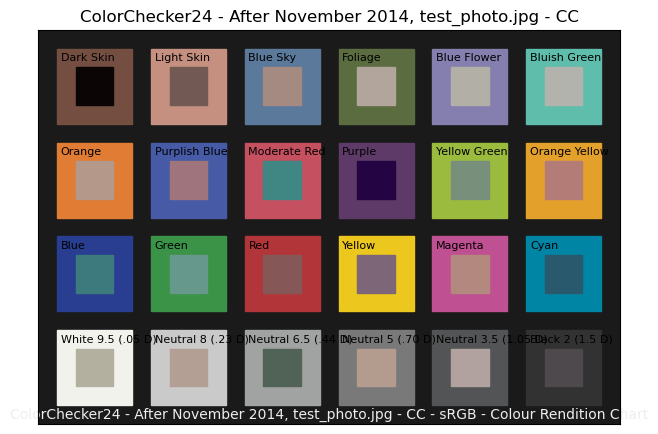

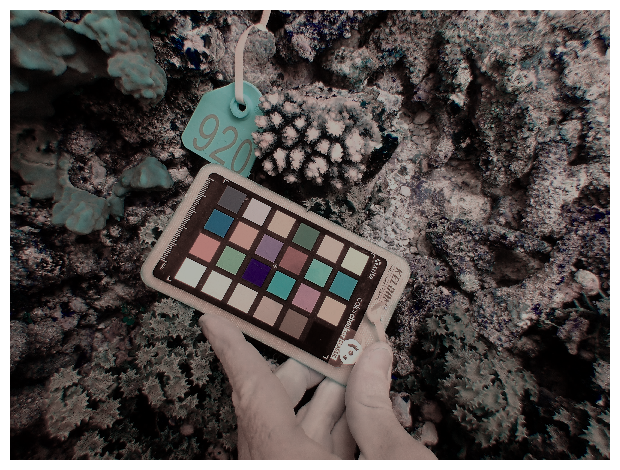

In [4]:
D65 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
REFERENCE_COLOUR_CHECKER = colour.CCS_COLOURCHECKERS[
    'ColorChecker24 - After November 2014']



colour_checker_rows = REFERENCE_COLOUR_CHECKER.rows
colour_checker_columns = REFERENCE_COLOUR_CHECKER.columns

# NOTE: The reference swatches values as produced by the "colour.XYZ_to_RGB"
# definition are linear by default.
# See https://github.com/colour-science/colour-checker-detection/discussions/59
# for more information.
REFERENCE_SWATCHES = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(list(REFERENCE_COLOUR_CHECKER.data.values())),
        'sRGB', REFERENCE_COLOUR_CHECKER.illuminant)

for i, swatches in enumerate(SWATCHES):
    swatches_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches, 'sRGB', D65))

    colour_checker = colour.characterisation.ColourChecker(
        os.path.basename(image_paths[i]),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_xyY)),
        D65, colour_checker_rows, colour_checker_columns)
    
    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker])
    
    swatches_f = colour.colour_correction(swatches, swatches, REFERENCE_SWATCHES)
    swatches_f_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches_f, 'sRGB', D65))
    colour_checker = colour.characterisation.ColourChecker(
        '{0} - CC'.format(os.path.basename(image_paths[i])),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_f_xyY)),
        D65, colour_checker_rows, colour_checker_columns)
    
    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker])

    colour.plotting.plot_image(colour.cctf_encoding(
        colour.colour_correction(
            images[i], swatches, REFERENCE_SWATCHES)));